In [2]:
!pip install fpdf

  Preparing metadata (setup.py) ... done
  Created wheel for fpdf: filename=fpdf-1.7.2-py2.py3-none-any.whl size=40704 sha256=35367bcaae1b0f4514dde6a3c9f5a93f27277ad314ed98c1dfa008183931dcea
  Stored in directory: /root/.cache/pip/wheels/65/4f/66/bbda9866da446a72e206d6484cd97381cbc7859a7068541c36
Successfully built fpdf


In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import davies_bouldin_score
from fpdf import FPDF

In [4]:
customers_df = pd.read_csv("Customers.csv")
transactions_df = pd.read_csv("Transactions.csv")

In [5]:
customers_df['SignupDate'] = pd.to_datetime(customers_df['SignupDate'])
transactions_df['TransactionDate'] = pd.to_datetime(transactions_df['TransactionDate'])

In [6]:
customers_df['SignupYear'] = customers_df['SignupDate'].dt.year

In [7]:
customer_transactions = transactions_df.groupby('CustomerID').agg(
    Total_Spent=('TotalValue', 'sum'),
    Total_Transactions=('TransactionID', 'count'),
    Avg_Spending=('TotalValue', 'mean'),
    Total_Quantity=('Quantity', 'sum')
).reset_index()

In [8]:
customer_data = pd.merge(customers_df, customer_transactions, on='CustomerID', how='left')


In [9]:
customer_data.fillna(0, inplace=True)


In [10]:
customer_data = pd.get_dummies(customer_data, columns=['Region'], drop_first=True)


In [11]:
features = ['Total_Spent', 'Total_Transactions', 'Avg_Spending', 'Total_Quantity',
            'SignupYear'] + [col for col in customer_data.columns if 'Region_' in col]


In [12]:
scaler = StandardScaler()
scaled_data = scaler.fit_transform(customer_data[features])

In [13]:
k_values = range(2, 11)
db_scores = []

In [14]:
for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    clusters = kmeans.fit_predict(scaled_data)
    db_scores.append(davies_bouldin_score(scaled_data, clusters))

In [15]:
best_k = k_values[db_scores.index(min(db_scores))]


In [16]:
kmeans_final = KMeans(n_clusters=best_k, random_state=42, n_init=10)
customer_data['Cluster'] = kmeans_final.fit_predict(scaled_data)

In [17]:
final_db_index = davies_bouldin_score(scaled_data, customer_data['Cluster'])


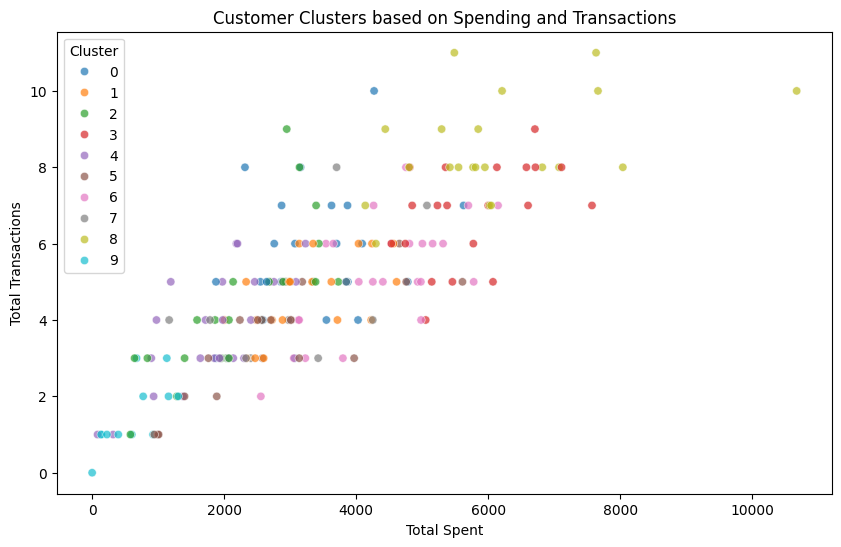

In [18]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x=customer_data['Total_Spent'], y=customer_data['Total_Transactions'],
                hue=customer_data['Cluster'], palette='tab10', alpha=0.7)
plt.title("Customer Clusters based on Spending and Transactions")
plt.xlabel("Total Spent")
plt.ylabel("Total Transactions")
plt.legend(title="Cluster")
plt.show()

In [19]:
customer_data.to_csv("Anshul_Meshram_Clustering.csv", index=False)


In [20]:
pdf = FPDF()
pdf.set_auto_page_break(auto=True, margin=15)
pdf.add_page()
pdf.set_font("Arial", "B", 16)
pdf.cell(200, 10, "Customer Segmentation Report", ln=True, align="C")


In [21]:
pdf.set_font("Arial", size=12)
pdf.ln(10)
pdf.multi_cell(0, 10, f"Optimal Number of Clusters: {best_k}\n")
pdf.multi_cell(0, 10, f"Davies-Bouldin Index: {final_db_index:.4f}\n")


[]

In [22]:
pdf.output("Anshul_Meshram_Clustering.pdf")


''

In [23]:
print(f"Optimal number of clusters: {best_k}")
print(f"Final Davies-Bouldin Index: {final_db_index}")

Optimal number of clusters: 10
Final Davies-Bouldin Index: 1.2399442945984902
